In [178]:
import copy as cp
import matplotlib.pyplot as plt
import numpy as np
import json
import time
FILEPATH = 'Teste/test3.json'
with open(FILEPATH) as f: #nu am implementat citirea numelor
  data = json.load(f)               #deoarece am lucrat in Google Collab
name = data['name']                 # deci cale fisierului va trebui sa
height = data['height']             # fie pusa manual
width = data['width']
rows = data['rows']
columns = data['columns']
grid = [[0 for i in range(width)] for j in range(height)]

In [179]:
def validHelper(grid, currentSequence, row, end, col): #functie ajutatoare pentru cea de mai jos
  if row == end:                                       #verifica daca lungimea unei secvente este egala 
    return False                                       #cu lungimea ceruta in conditia de coloana
  sequenceLength = 0
  while grid[row][col] and row <= end:
    row += 1
    sequenceLength += 1
    if row > end:
      break
  
  return (sequenceLength == currentSequence), sequenceLength, row

def enoughSpace(columns, nrRowsLeft):      #verifica pentru o coloana a gridului daca mai
  minSizeNeeded = 0                        # este spatiu suficient dintr-un punct anume 
  for currentSequence in columns:          # pentru a completa toate secventerle ramase
    minSizeNeeded += currentSequence
    minSizeNeeded += 1
  minSizeNeeded -= 1
  return nrRowsLeft >= minSizeNeeded


def isValid(grid, columns, height, width): #verifica daca un grid respecta conditiile de coloane
  for col in range(width):
    row = 0
    for currentSequence in columns[col]:     #pentru fiecare conditie de coloana verifica daca se gaseste secventa respectiva
      while not grid[row][col] and row < height - 1:     #trece de campurile necolorate
        row += 1
      if row == height - 1:                      #daca s-a ajuns la ultimul camp din coloana iar nici acesta
        if not grid[row][col]:                   #nu este colorat, se poate spune clar ca nu se respecta conditiile(daca erau nule nu se intra in for)
          return False
        else:
          break
      sequenceFound, sequenceLength, row = validHelper(grid, currentSequence, row, height - 1, col)
      if not sequenceFound:
        return False
  return True
def canWork(grid, columns, height, width, currHeight): #verifica pentru un grid pana un punct anume daca acesta mai
  if currHeight == height:                                   # poate fi expandat intr-o solutie corecta
    return isValid(grid, columns, height, width)
  for col in range(width):
    row = 0
    currSequenceIndex = 0
    for currentSequence in columns[col]:
      while not grid[row][col] and row < currHeight - 1:
        row += 1
      if row == currHeight - 1:
        if not enoughSpace(columns[col][currSequenceIndex:], height -  currHeight + 1):
          return False
        else:
          break
      sequenceFound, sequenceLength, row = validHelper(grid, currentSequence, row, currHeight - 1, col)
      if not sequenceFound:
        if sequenceLength < currentSequence:  #spre deosebire de isValid, canWork accepta o lungime mai mica a
          if row > currHeight - 1:            # secventei daca s-a ajuns la ultimul rand de verificat(secventa s-ar putea continua in grid)
            if not enoughSpace(columns[col][currSequenceIndex:], height - currHeight + sequenceLength):
              return False
            else:
              break
          else:
            return False
        else:
          return False
      currSequenceIndex += 1
  return True




        
  

In [180]:
def getMinFreeSpace(sequencesLeft):  #returneaza spatiul minim necesar pentru a putea termina toate secventele
  minFreeSpace = 0
  for sequence in sequencesLeft:
    minFreeSpace += sequence + 1
  return minFreeSpace - 2

def getRowValidPermutations(rowSequences, width, sequenceIndex, startPosition): #returneaza o lista de liste ce contine
  if rowSequences == []:                                                        #, pentru un rand, toate permutarile pentru care sunt respectate conditiile de rand
    return []
  permutationsList = []
  endPosition = width - getMinFreeSpace(rowSequences[sequenceIndex:])
  #if sequenceIndex == len(rowSequences) - 1:
  # endPosition += 1
  for i in range(startPosition, endPosition):
    if sequenceIndex == len(rowSequences) - 1:
      permutationsList += [[i]]
    else:
      permutationsList += list(map(lambda x: [i] + x, getRowValidPermutations(rowSequences, width, sequenceIndex + 1, i + rowSequences[sequenceIndex] + 1)))
  return permutationsList


node = {'index': INT, 'level': INT, 'children' = {...}, 'positions': []} structura nodului pentru cautarea dfs


In [181]:
def applyPositionsToGrid(grid, sequences, positions, row):  #coloreaza secventele date, pe pozitile alese pentru un rand anume
  for i in range(len(positions)):
    sequenceIterator = sequences[i]
    while sequenceIterator:
      grid[row][positions[i] + sequences[i] - sequenceIterator] = 1
      sequenceIterator -= 1



INDEX = 'index'
LEVEL = 'level'
CHILDREN = 'children'
POS = 'positions'

nextNodeIndex = 1 
def dfsSearch(grid, node, height, width, rows, columns): #algoritmul dfs. Va returna solutia ca lista de indici de noduri
  global nextNodeIndex
  if node[LEVEL] != -1:    #daca nodul nu este cel radacina se aplica pozitile generate pentru nod
    applyPositionsToGrid(grid, rows[node[LEVEL]], node[POS], node[LEVEL])
    if not canWork(grid, columns, height, width, node[LEVEL] + 1): #daca nu se mai poate genera o solutie din punctul actual
      return False                                                 #returneaza fals
  if node[LEVEL] == height - 1:                          #daca sa ajuns la ultimul nivel se verifica daca grid-ul este o solutie sau nu
    if not isValid(grid, columns, height, width):
      return False
    else:
      return [node[INDEX]]
  
  permutationsList = getRowValidPermutations(rows[node[LEVEL] + 1], width, 0, 0) #se genereaza permutarile
  nrBlankRows = 0                               
  while permutationsList == []:                   #se trece peste randurile ce au un set de secvente vid
    nrBlankRows += 1
    permutationsList = getRowValidPermutations(rows[node[LEVEL] + nrBlankRows + 1], width, 0, 0)

  for position in permutationsList: #se creeaza un copil pentru fiecare permutare posibila
    childNode = {}
    childNode[INDEX] = nextNodeIndex
    childNode[LEVEL] = node[LEVEL] + nrBlankRows + 1
    childNode[CHILDREN] = {}
    childNode[POS] = position
    node[CHILDREN][nextNodeIndex] = childNode
    nextNodeIndex += 1
    continuedSolution = dfsSearch(cp.deepcopy(grid), childNode, height, width, rows, columns) #se apeleaza dfs pe copil
    if continuedSolution:
      if node[LEVEL] != -1:            #se adauga la solutia returnata indicele nodului si -1 pentru fiecare rand vid dinaintea lui
        for i in range(nrBlankRows):
          continuedSolution.insert(0, -1)
        continuedSolution.insert(0, node[INDEX]) 
      return continuedSolution
    
  return False


def generateGrid(grid, root, rows, height, width, solution): #se genereaza gridul pe baza listei de noduri solutie
  if solution == False:
    print('Nu a fost gasita o solutie')
  nodeIter = root
  for currentRowsolution in solution:
    if currentRowsolution != -1:
      nodeIter = nodeIter['children'][currentRowsolution]
      applyPositionsToGrid(grid, rows[nodeIter[LEVEL]], nodeIter[POS], nodeIter[LEVEL])





node = {'index': INT, 'level': INT, 'children' = {...}, 'positionsList': [[]]} pentru cautarea bfs singura modificare va fi faptul ca  vom retine in positions si pozitile nodurilor stramos

In [182]:
POSLIST = 'positionsList'
nextNodeIndexBFS = 0
def bfsSearch(grid, node, height, width, rows, columns):
  global nextNodeIndexBFS
  queue = []
  queue.append(node)
  while len(queue) > 0:
    currNode = queue.pop()
    if currNode[LEVEL] != -1:
      grid = [[0 for i in range(width)] for j in range(height)]
      currentPositionIndex = 0
      for positions in node[POSLIST]:
        applyPositionsToGrid(grid, rows[node[LEVEL]], positions[i], currentPositionIndex)
        currentPositionIndex += 1
      if not canWork(grid, columns, height, width, node[LEVEL] + 1):
        continue
      if node[LEVEL] == height - 1:
        if not isValid(grid, columns, height, width):
          continue
        else:
          return node[POSLIST]
    if node[LEVEL] < height - 1:
      permutationsList = getRowValidPermutations(rows[node[LEVEL] + 1], width, 0, 0)
      nrBlankRows = 0
      while permutationsList == []:
        nrBlankRows += 1
        permutationsList = getRowValidPermutations(rows[node[LEVEL] + nrBlankRows + 1], width, 0, 0)
      for position in permutationsList:
        childNode = {}
        childNode[INDEX] = nextNodeIndexBFS
        childNode[LEVEL] = node[LEVEL] + nrBlankRows + 1
        childNode[CHILDREN] = {}
        childNode[POSLIST] = cp.deepcopy(node[POSLIST])
        for i in range(nrBlankRows):
          childNode[POSLIST].append([])
        childNode[POSLIST].append(position)
        node[CHILDREN][nextNodeIndexBFS] = childNode
        nextNodeIndexBFS += 1
        queue.append(childNode)
  return False
def applyBFSResultToGrid(grid, solution, rows, width, height):
  rowIndex = 0
  if solution == False:
    print('Nu a fost gasita o solutie')
  for positions in solution:
    applyPositionsToGrid(grid, rows[rowIndex], positions, rowIndex)




    

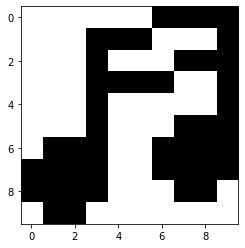

In [183]:
root = {}
root[INDEX] = 0
root[LEVEL] = -1
root[CHILDREN] = {}
root[POS] = []
startTime = time.process_time()
solution = dfsSearch(grid, root, height, width, rows, columns)
generateGrid(grid, root, rows, height, width, solution)
finishTime = time.process_time()
output = {}
output['strategy'] = 'dfs'
output['nodesGenerated'] = nextNodeIndex
output['nodesExpanded'] = nextNodeIndex
output['time'] = finishTime - startTime
output['solution'] = grid
with open('Outputs/output_' + name +'_dfs.json', 'w') as outputFile: #trebuie creat folderul Outputs sau modificata calea
  json.dump(output, outputFile)

#decomentati pentru reprezentarea grafica a nonogramei
#npGrid = np.matrix(grid)
#G = np.zeros((height, width, 3))
#G[npGrid>0.5] = [0, 0, 0]
#G[npGrid<0.5] = [1, 1, 1]
#plt.imshow(G, interpolation = 'nearest')
#plt.show()


In [170]:
#BFS. NU RULATI!! NU FUNCTIONEAZA
root = {}
root[INDEX] = 0
root[LEVEL] = -1
root[CHILDREN] = {}
root[POSLIST] = []
grid = [[0 for i in range(width)] for j in range(height)]
solution = bfsSearch(grid, root, height, width, rows, columns)
applyBFSResultToGrid(grid, solution, rows, width, height)
npGrid = np.matrix(grid)
G = np.zeros((height, width, 3))
G[npGrid>0.5] = [0, 0, 0]
G[npGrid<0.5] = [1, 1, 1]
plt.imshow(G, interpolation = 'nearest')
plt.show()


KeyboardInterrupt: ignored